In [2]:
import codecs
import csv
#import argparse
import os
import numpy as np
import pickle
import pandas as pd

#from dill import dill
#from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
#from sklearn import cross_validation, svm
#from sklearn.svm import LinearSVC
#from sklearn.svm import SVC
#from sklearn.multiclass import OneVsRestClassifier
#from sklearn.tree.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score, classification_report, accuracy_score, recall_score, precision_score


# modulo per confrontare il risultato delle regex
# richiede entrambi i db già etichettati
#import tortellino_parmigiano 
import crea_db


import evaluation_report # stampa confusion_matrix e altro
#from text_tokenizer import get_tokenizer 

In [48]:
DATA_FOLDER = "/home/backup/dati_e_csv/" # DATI


# ci assicuriamo siano presenti i DB
training_db_name = crea_db.build_training(OUTPUT=DATA_FOLDER)
test_db_name = crea_db.build_test(OUTPUT=DATA_FOLDER) ################################

texts_raw = list()
labels = list()
names= []

# load training dataset # possiamo usare sqlite
with codecs.open(os.path.join(DATA_FOLDER, training_db_name), 'r', errors='ignore') as file:
    reader = csv.reader(file, delimiter=';')
    etichette = next(reader)
    for row in reader:
        # load documents
        #print('Nome {}, etichette {}, conversazione{}'.format(row[10], row[:10], row[11]+row[12]))
        #raise SystemExit
        unito = row[11].replace('#O:', '') + row[12].replace('#C:', '') #concatena il testo cliente con operatore
        texts_raw.append(unito)
        # load row name
        names.append(row[10])
        # load labels
        labels.append(list(map(lambda x: int(x), row[:10])))
Y = np.array(labels)
print(len(texts), len(labels))
# tokenization function # possiamo usare anche solo un canale cliente/operatore
print('Dati caricati')

ita_stopwords = set(stopwords.words('italian'))
ita_stemmer = ItalianStemmer()
ita_stemming = ita_stemmer.stem

def get_tokenizer(doc): #(word_ngrams=None, char_ngrams=None, stopwords=None, additional_extractors=None):
    doc = filter(lambda x: x not in ita_stopwords, word_tokenize(doc))
    #doc = map(ita_stemming, doc)
    #doc = [ita_stemmer.stem(a) for a in doc]
    temp = ''
    for par in doc:
        temp = '{} {}'.format(temp, ita_stemming(par))
    return temp
#building data and trying some features selection

#print(texts[:2], Y)
# if os.path.exists('/home/backup/dati_e_csv/training_stemmed_NB.pickle'):
#     with open('/home/backup/dati_e_csv/training_stemmed_NB.pickle', 'r') as stem_pick:
#         stemmed_train = pickle.load(stem_pick)
# else:
#     stemmed_train = list(map(get_tokenizer, texts))
#     print('Stemmati!')
#     # salva le trascrizioni stemmate

#     with open('/home/backup/dati_e_csv/training_stemmed_NB.pickle', 'wb') as salvataggio:
#         pickle.dump(stemmed_train, salvataggio, protocol=0)
print('ok')

Training sqlite e csv presenti!
Test sqlite e csv presenti!
10 24379
Dati caricati
ok


In [4]:
texts[1]

"  sì  hanno hanno inviato documentazioni fonte signora  numero cliente vediamo signora  non ho il numero cliente  al  senza essere persone nella  il ministro con tutto toccata  perché allora nella documentazione che lei abbia inviato  risultava barche non vi era correttamente compilata  marcato alla Castelli fiscale su questa delicata  è molto  estremo non ce l' ho ancora signora questa anzi mi serve il venticinque di agosto  allora no signora lì di fronte a stare domani pomeriggio sul tasti perché i documenti lender lavorasse nel giro di quarantotto ore  quindi vedete ricontattare domani verso il tardi per vedere se sono pervenuti i documenti  va bene  io non ce l' ho ancora  non c'è ancora tutta  no con il nono bis signora non non non c'è proprio  non lo so signora io non lo vedo  grazie buongiorno  non c'è concorrenza  più o meno come fare la pratica perché è un po' di giorni ti aspetto  sì presa fatto tutto ha mandato il fax e avremo compilato un po' in  Como ottenendo Torino alle

In [65]:
# Build data matrix for training set
count_vect = CountVectorizer(max_df=1.0, min_df=0.001)
print('building TD matrix...')
try: 
    X_train_counts = count_vect.fit_transform(texts_raw) #stemmed_train
except:
    print('Bisogna riavviare il blocco 18 !!!!!')
    
print('raw DT matrix shape: {}, {}'.format(X_train_counts.shape[0],X_train_counts.shape[1]))

inverse_vocab = { v:k for k,v in count_vect.vocabulary_.items()} # serviva per esplorare le fatures, non piu utile

# IL TF peggiora nettamente 
# TF-IDF
#tf_transformer = TfidfTransformer(use_idf=True)#.fit(X_train_counts)
#X_train_tf = tf_transformer.fit_transform(X_train_counts)
#print(X_train_tf.shape)
#print('term-document matrix shape after tfid: {}, {}'.format(X_train_tf.shape[0],X_train_tf.shape[1]))
print('chi2...')
chi_k = []
chi_features = []
texts = []
k = (4000,1500,2500,5000,2500,2500,1500,3000,3000,5000)
#k = (300,300,300,300,300,300,300,300,300,300)
scores = []
feat = []
for i in range(Y.shape[1]):
    feat.append(SelectKBest(chi2, k = 2500))
    texts.append(feat[i].fit_transform(X_train_counts,Y[:,i])) # fitto tanti modelli quante classi, per ogni classe faccio la feature selection
    scores.append(feat[i].pvalues_)
    chi_k.append(feat[i].get_support(indices=True))
    chi_features.append(texts[i])
print('ok')

#print('term-document matrix semplified: {}, {}'.format(texts.shape[0],texts.shape[1]))

building TD matrix...
raw DT matrix shape: 24379, 9969
chi2...
ok


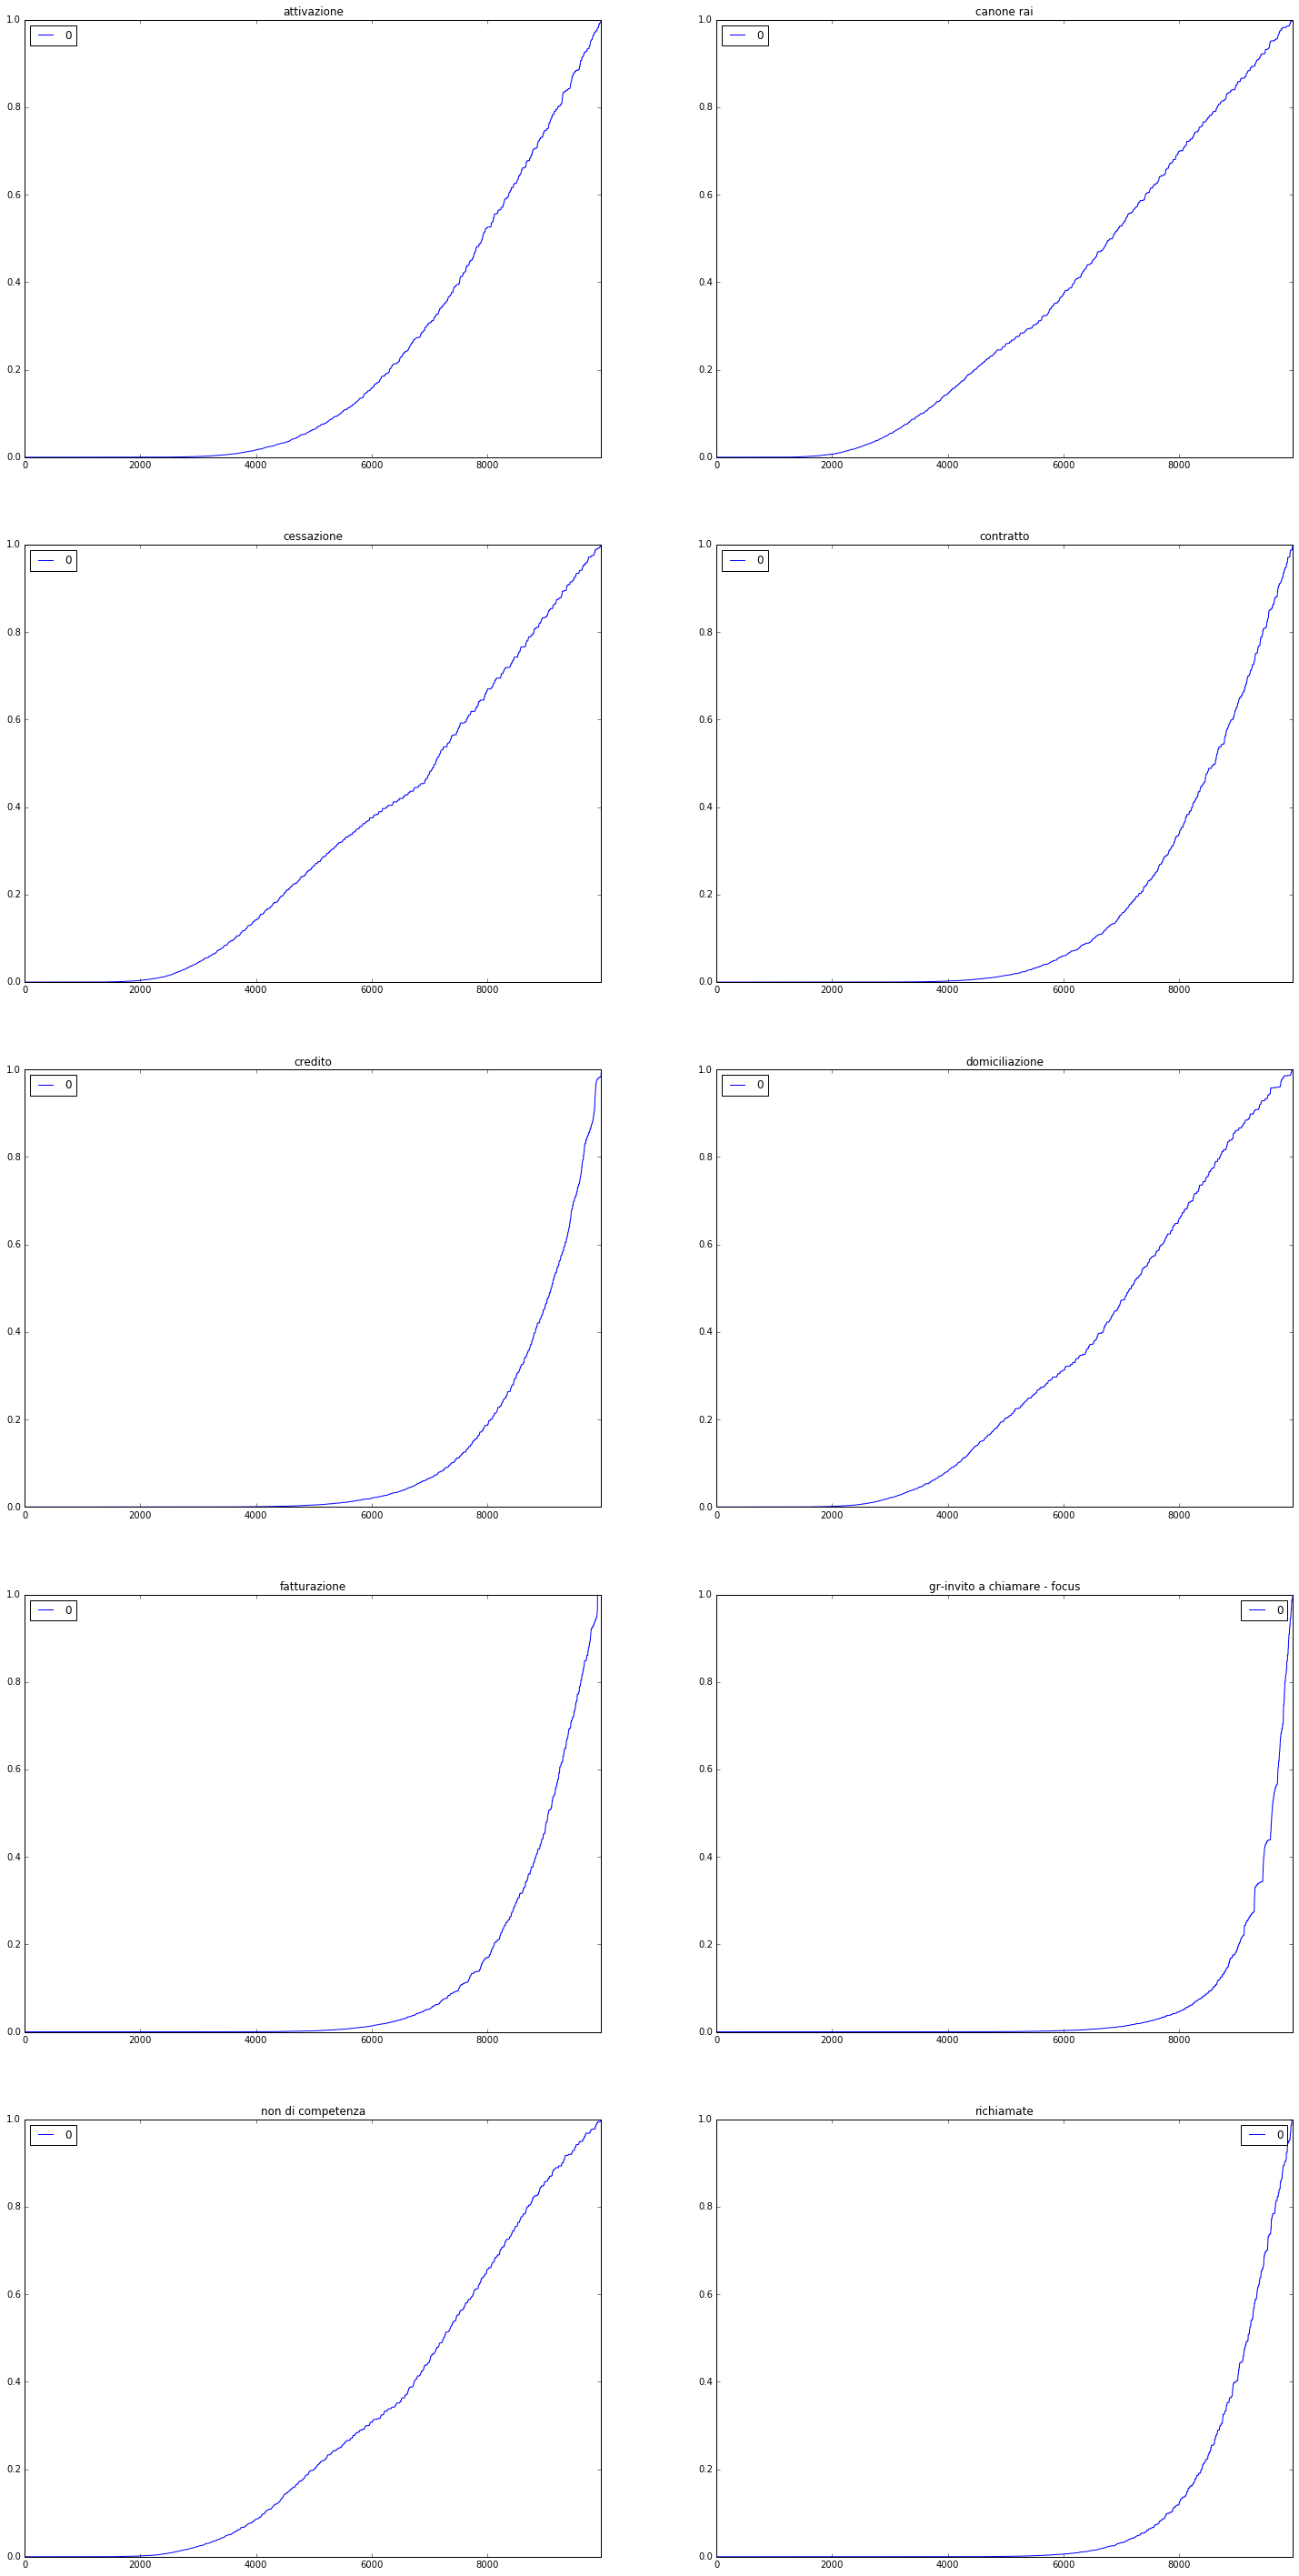

In [66]:
# PLOT p-values 

import matplotlib.pyplot as plt 
%matplotlib inline 
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25,50))

import pandas as pd
#pd_scores = pd.DataFrame(scores[0])
#pd_scores.head()
#pd_inverse_vocab = pd.DataFrame.from_dict(inverse_vocab, orient='index')
#pd_inverse_vocab
#pd_scores[1] = pd_inverse_vocab[0]
#pd_scores = pd_scores.sort_values(by=0, ascending=1)
#pd_scores
#print(pd_scores.head())


#pd_scores[pd_scores[0] < 1e-2].dropna()
for i in range(Y.shape[1]):
    pd_scores = pd.DataFrame(scores[i])
    pd_scores = pd_scores.sort_values(by=0, ascending=1)
    if i % 2 == 0:
        pd_scores.plot(use_index=False, ax=axes[int(i/2), 0]).set_title(etichette[i])
    else:
        pd_scores.plot(use_index=False, ax=axes[int(i/2), 1]).set_title(etichette[i])
    
plt.show()


In [67]:
# esploro le feature selezionate dando un occhio ai p-values
l, m = list(), list()
for i,k in enumerate(chi_k[1]):
    #print('{} {}'.format(inverse_vocab[k], scores[1][i]))
    l.append(inverse_vocab[k])
    m.append(scores[1][i])

print(scores[1].mean(), np.median(scores[1]), scores[1].min(), scores[1].max())

0.337839120192 0.253007617347 0.0 0.999677199027


In [68]:
# print the most correlated words in canone-rai
pval_pd = pd.Series(m, index=l)
pval_pd.sort_values(ascending=True).head(20)

mussolini             0.000000e+00
cambia                0.000000e+00
lire                  0.000000e+00
provvedendo           0.000000e+00
andava                0.000000e+00
cosa                 5.225615e-271
ottantasette         1.284574e-237
centosettantanove    1.186010e-233
livello              4.524926e-199
sei                  3.186090e-174
cessa                3.179408e-166
musei                1.154397e-147
vuota                3.750485e-142
corsa                8.264612e-133
stanza               2.495711e-124
comunque             5.847374e-124
batte                2.295865e-111
lato                 1.864892e-109
istanza              8.112573e-109
parla                1.851805e-108
dtype: float64

In [67]:
pval_pd.loc['rai']

1.151324855634789e-27

In [69]:
#algo = OneVsRestClassifier(MultinomialNB(), n_jobs=1) 
#print('Multilabel ', algo.multilabel_)
model = []
for i in range(Y.shape[1]):
    #clf = OneVsRestClassifier(MultinomialNB(), n_jobs=2)
    class_proba = np.sum(Y[:,i])/Y.shape[0]
    print('class probability {:<20}: {:.3g}%'.format(etichette[i], class_proba*100))
    model.append(MultinomialNB())
    # model for the first class
    model[i].fit(chi_features[i], Y[:,i])
print('modelli creati')

class probability attivazione         : 9.56%
class probability canone rai          : 3.93%
class probability cessazione          : 2.19%
class probability contratto           : 14.9%
class probability credito             : 49.8%
class probability domiciliazione      : 3.39%
class probability fatturazione        : 20%
class probability gr-invito a chiamare - focus: 46.3%
class probability non di competenza   : 3.36%
class probability richiamate          : 10.3%
modelli creati


In [5]:
######################## learning curve plot
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import learning_curve
from sklearn.ensemble import VotingClassifier

def pari(i):
    if i%2 == 0:
        return 0
    else:
        return 1

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), i=0):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/home/utente_locale/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/utente_locale/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/utente_locale/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/utente_locale/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


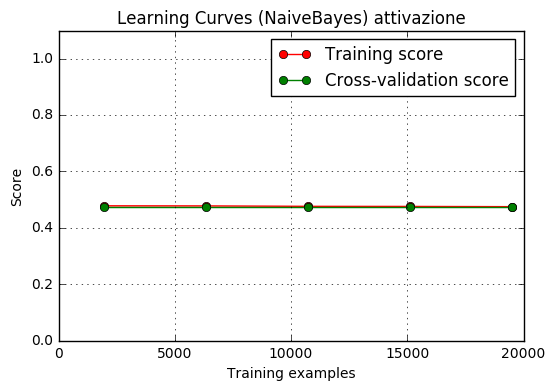

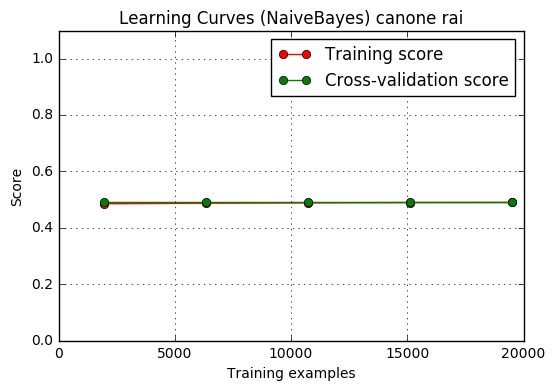

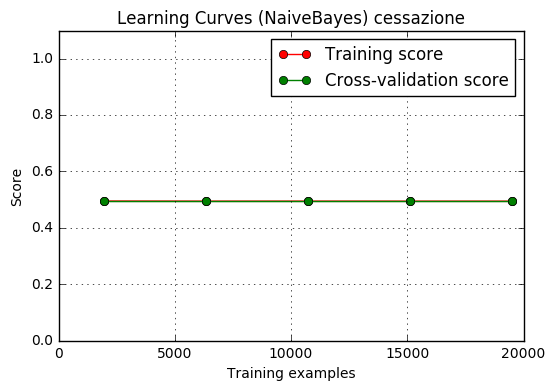

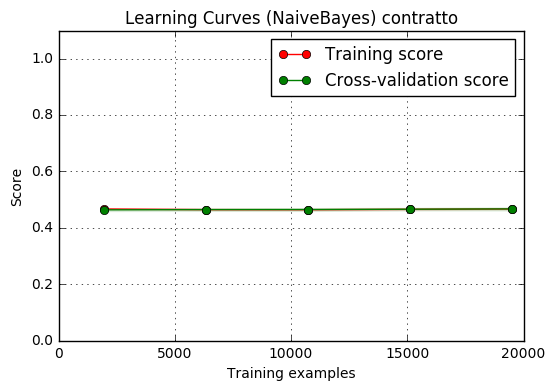

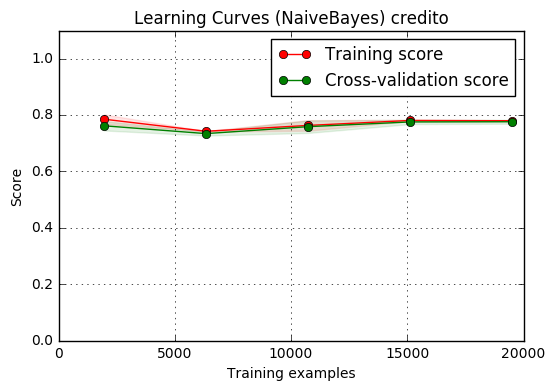

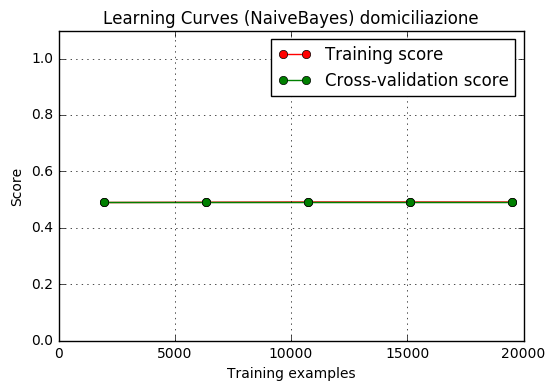

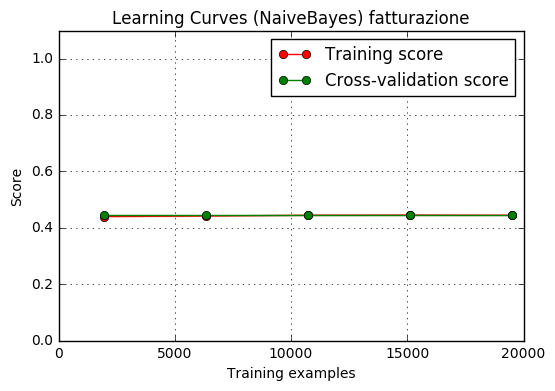

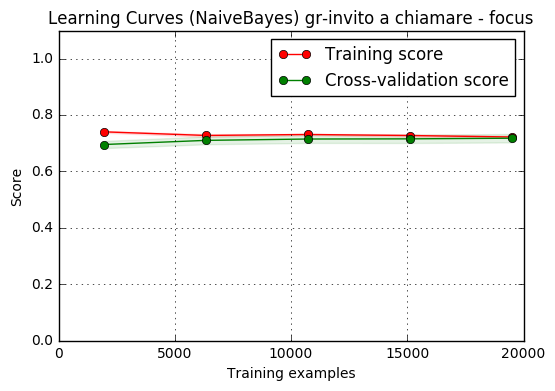

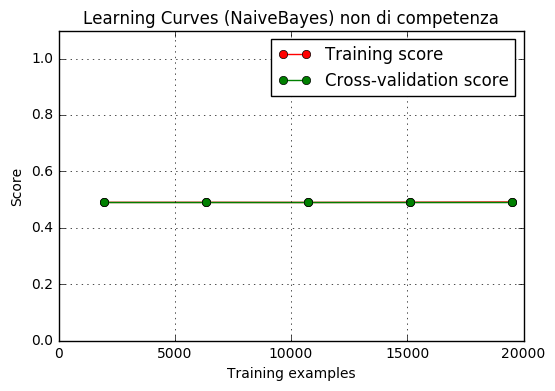

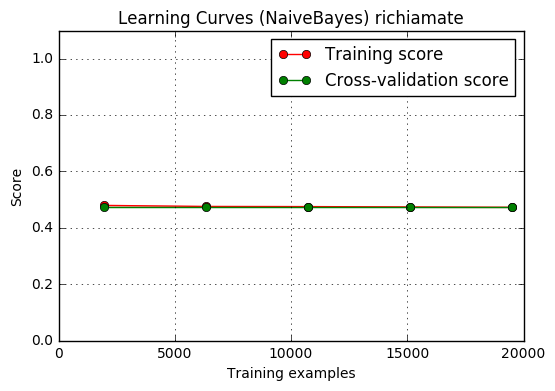

In [6]:
estimators = model
#svm_all = VotingClassifier(estimators)
#fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25,50))

#print(matrix_countvect.shape)
#print(etichette_train_set.shape)
for i in range(Y.shape[1]):
    title = "Learning Curves (NaiveBayes) " + etichette[i]
    plot_learning_curve(estimators[i], title, chi_features[i], Y[:,i], (0, 1.1), cv=5, n_jobs=-1)
plt.show()

In [70]:
# importo il test set per la valutazione del modello
unito_test = []
names_test = []
test_texts = list()
test_labels = list()
#raise SystemExit

# load test data
# carica il test set
with codecs.open(os.path.join(DATA_FOLDER, test_db_name), 'r', errors='ignore') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader)
    print(etichette)
    for row in reader:
        # load documents
        test_texts.append(row[1]+row[2].replace('#O:', '').replace('#C:', ''))
        # load names
        names_test.append(row[0])
        # load labels
        test_labels.append(list(map(lambda x: int(x),row[-10:])))
        
#stemmed_test = list(map(get_tokenizer, test_texts))
print('test set caricato')
# feature selection sul test set
test_feat = []
test_DT = count_vect.transform(test_texts)#stemmed_test
#test_DT = tf_transformer.transform(test_DT)
for i in range(Y.shape[1]):
    test_feat.append(feat[i].transform(test_DT))


['attivazione', 'canone rai', 'cessazione', 'contratto', 'credito', 'domiciliazione', 'fatturazione', 'gr-invito a chiamare - focus', 'non di competenza', 'richiamate', 'xml name', 'testo operatore', 'testo cliente']
test set caricato


In [71]:
Y_test = np.array(test_labels)
predicted_labels = np.zeros(shape=(len(test_texts), Y.shape[1]))
for i in range(Y.shape[1]):
    #Y_test = numpy_test[:,i]
    predicted_labels[:,i] = model[i].predict(test_feat[i]) #np_array

# apply model to data
print(test_DT.shape)

# print evaluation report
evaluation_report.print_evaluation(Y_test, predicted_labels)
#for i in range(predicted_labels.shape[1]):
    #print(etichette[i], np.sum(predicted_labels[:,i]))
#print('Decision function: ')

#print("classification report:")
#print(classification_report(Y_test,predicted_labels, target_names=etichette))
#for i in range(predicted_labels.shape[1]):
#    print(etichette[i], np.sum(predicted_labels[:,i]))

(424, 9969)
[[0 1 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 1 0 0 0]
 [1 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Confusion matrix attivazione
[[315  36]
 [ 23  50]]
Confusion matrix canone rai
[[355   6]
 [ 33  30]]
Confusion matrix cessazione
[[385  29]
 [  7   3]]
Confusion matrix contratto
[[306  44]
 [ 29  45]]
Confusion matrix credito
[[188  74]
 [ 25 137]]
Confusion matrix domiciliazione
[[363  40]
 [  4  17]]
Confusion matrix fatturazione
[[240  60]
 [ 80  44]]
Confusion matrix gr-invito a chiamare - focus
[[213 188]
 [  2  21]]
Confusion matrix non di competenza
[[360  14]
 [ 42   8]]
Confusion matrix richiamate
[[343  78]
 [  1   2]]
                              precision    recall  f1-score   support

                 attivazione       0.58      0.

In [32]:
print('\n')
print('accuracy', accuracy_score(Y_test, predicted_labels))
print('precision micro',precision_score(Y_test, predicted_labels, average='micro') )
print('recall micro',recall_score(Y_test, predicted_labels, average='micro'))
print('f1 micro', f1_score(Y_test, predicted_labels, average='micro'))
print('precision macro', precision_score(Y_test, predicted_labels, average='macro') )
print('recall macro', recall_score(Y_test, predicted_labels, average='macro'))
print('f1 macro', f1_score(Y_test, predicted_labels, average='macro'))




accuracy 0.134433962264
precision micro 0.393018018018
recall micro 0.578772802653
f1 micro 0.468142186452
precision macro 0.398852893113
recall macro 0.559863501471
f1 macro 0.389974913671


In [8]:
print(test_feat[1])

  (0, 355)	1
  (0, 354)	1
  (0, 349)	1
  (0, 341)	1
  (0, 336)	1
  (0, 335)	1
  (0, 334)	1
  (0, 328)	1
  (0, 326)	1
  (0, 325)	1
  (0, 321)	1
  (0, 312)	1
  (0, 307)	1
  (0, 304)	1
  (0, 298)	1
  (0, 297)	1
  (0, 295)	1
  (0, 281)	1
  (0, 278)	1
  (0, 270)	1
  (0, 267)	1
  (0, 265)	1
  (0, 262)	1
  (0, 259)	2
  (0, 251)	2
  :	:
  (423, 105)	1
  (423, 98)	2
  (423, 94)	2
  (423, 82)	1
  (423, 79)	1
  (423, 74)	1
  (423, 66)	1
  (423, 64)	2
  (423, 50)	2
  (423, 48)	2
  (423, 47)	1
  (423, 44)	1
  (423, 43)	1
  (423, 42)	1
  (423, 38)	3
  (423, 35)	1
  (423, 32)	1
  (423, 29)	1
  (423, 25)	1
  (423, 22)	2
  (423, 16)	1
  (423, 8)	2
  (423, 5)	1
  (423, 3)	2
  (423, 1)	2


In [9]:
print(chi_features[1])

  (0, 188)	0.096603276711
  (0, 35)	0.100565410371
  (0, 121)	0.0759378704737
  (0, 259)	0.0719898530932
  (0, 30)	0.0966888855204
  (0, 220)	0.0787766310648
  (0, 48)	0.0802461116881
  (0, 305)	0.119987232909
  (0, 97)	0.0924908221579
  (0, 349)	0.136819301987
  (0, 150)	0.301022430257
  (0, 223)	0.100194700015
  (0, 15)	0.108792231955
  (0, 166)	0.0795137061332
  (0, 103)	0.109604591216
  (0, 327)	0.0873132563943
  (0, 277)	0.151981710354
  (0, 135)	0.100006480738
  (0, 245)	0.104543962259
  (0, 87)	0.0667946837514
  (0, 27)	0.0987731520403
  (0, 2)	0.0822410332648
  (0, 189)	0.147716715034
  (0, 8)	0.0652415917134
  (0, 111)	0.166729346689
  :	:
  (24378, 158)	0.13074204187
  (24378, 167)	0.124602164309
  (24378, 42)	0.0923423513949
  (24378, 106)	0.140745180531
  (24378, 360)	0.111505311385
  (24378, 243)	0.157042421736
  (24378, 90)	0.116855300672
  (24378, 47)	0.0953239096633
  (24378, 246)	0.117332379446
  (24378, 295)	0.140632684232
  (24378, 192)	0.143792350304
  (24378, 220)	